# Observation of the data from smart sensor tag
>從 sensor 上讀到的資料，在不同時間分別上傳到 MCS 和 firebase 兩個平台上。使用 MCS 上的資料作為 training data 及研究 pre-processing 的依據，firebase 的資料作為 testing data 及研究成果判斷。

In [1]:
# import packages
import requests
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
from datetime import datetime
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cross_validation import train_test_split

/Users/claireliu/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# device DATA: SST-mpu-0001-2
deviceId = "DPUsU10G"
deviceKey = "xtnTV0Wefm3NWzk2"
limit = 1000

# defining params
PARAMS = {'deviceKey': deviceKey, 'Content-Type' : 'application/json'} 

In [3]:
def combineURL (datachannels):
    URL = "https://api.mediatek.com/mcs/v2/devices/" + deviceId
    URL += "/datachannels/" + datachannels
    URL += "/datapoints?limit=" + str(limit)
    URL += "&order=asc"
    return URL

In [4]:
def requestData (datachannels):
    URL = combineURL(datachannels)
    r = requests.get(url = URL, params = PARAMS) 
    data = r.json()['dataChannels'][0]['dataPoints']
    for item in data:
        item[datachannels] = item['values']['value']
    df = pd.DataFrame(data, columns=['recordedAt', datachannels])
    return df

In [5]:
def changeToDatetime (ts):
    s, ms = divmod(ts, 1000)
    dtstr = datetime.fromtimestamp(s).strftime('%Y-%m-%d %H:%M:%S')
    dt = datetime.strptime(dtstr, '%Y-%m-%d %H:%M:%S')
    return dt

## Step 1: Catch data from MCS

In [6]:
channels = ['roll', 'yaw', 'pitch', 'accelX', 'accelY', 'accelZ', 'gyroX', 'gyroY', 'gyroZ']
df = pd.DataFrame()
for ch in channels:
    # sending GET request
    tmp = requestData(ch)
    if(df.empty): df = tmp
    else: df = pd.merge(df, tmp, on='recordedAt')

## Step 2: View data
### reference:
1. [Basic statistics in pandas DataFrame]('https://medium.com/@kasiarachuta/basic-statistics-in-pandas-dataframe-594208074f85')

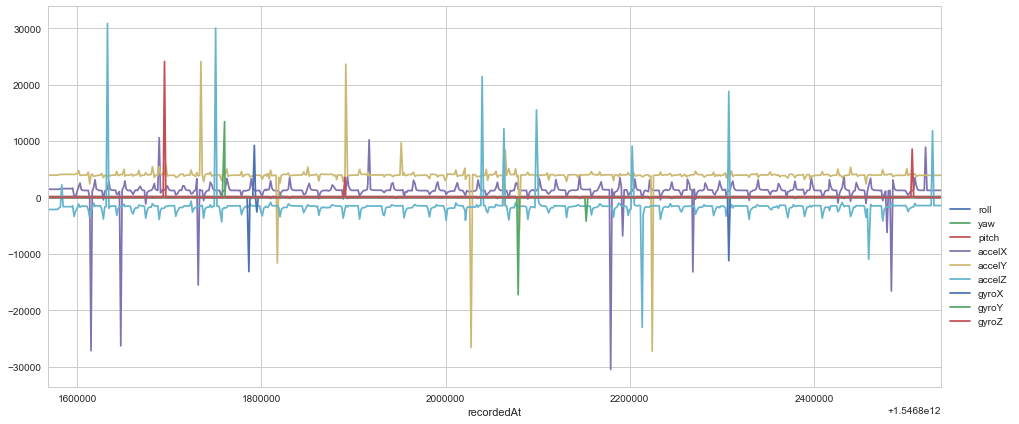

In [7]:
df.plot(x='recordedAt', figsize=(16,7)).legend(loc=2, bbox_to_anchor=(1, 0.5))

In [8]:
df.shape

(648, 10)

In [9]:
df.dtypes

recordedAt      int64
roll          float64
yaw           float64
pitch         float64
accelX          int64
accelY          int64
accelZ          int64
gyroX           int64
gyroY           int64
gyroZ           int64
dtype: object

In [10]:
df.describe().astype(np.int64).T

,count,mean,std,min,25%,50%,75%,max
recordedAt,648,1546802051849,280413,1546801568435,1546801809509,1546802050926,1546802294519,1546802537860
roll,648,110,4,39,110,110,112,122
yaw,648,-4,28,-38,-23,-13,5,133
pitch,648,156,49,-179,162,163,164,179
accelX,648,1132,2481,-30506,1193,1262,1405,10586
accelY,648,3916,2218,-27238,3920,3966,4051,24106
accelZ,648,-1537,2647,-23032,-1794,-1542,-1481,30830
gyroX,648,-27,776,-13148,-1,0,0,9233
gyroY,648,-12,874,-17232,-1,0,0,13434
gyroZ,648,55,1014,-25,-1,0,0,24108


## Step 3-1: Preprocessing: removing outliers

> 從下方圖表可以看到所有資料欄位都存在一些極端值，因此我們先處理掉

### reference:
1. [Ways to Detect and Remove the Outliers]('https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba')
2. [使用pandas進行數據清洗]('https://hk.saowen.com/a/ac6c81ad3f801cf0aecd4bfa890786313eb2672563b1f0e91318c91e0475612b')
3. [replace outliers | Kaggle]('https://www.kaggle.com/general/24617')

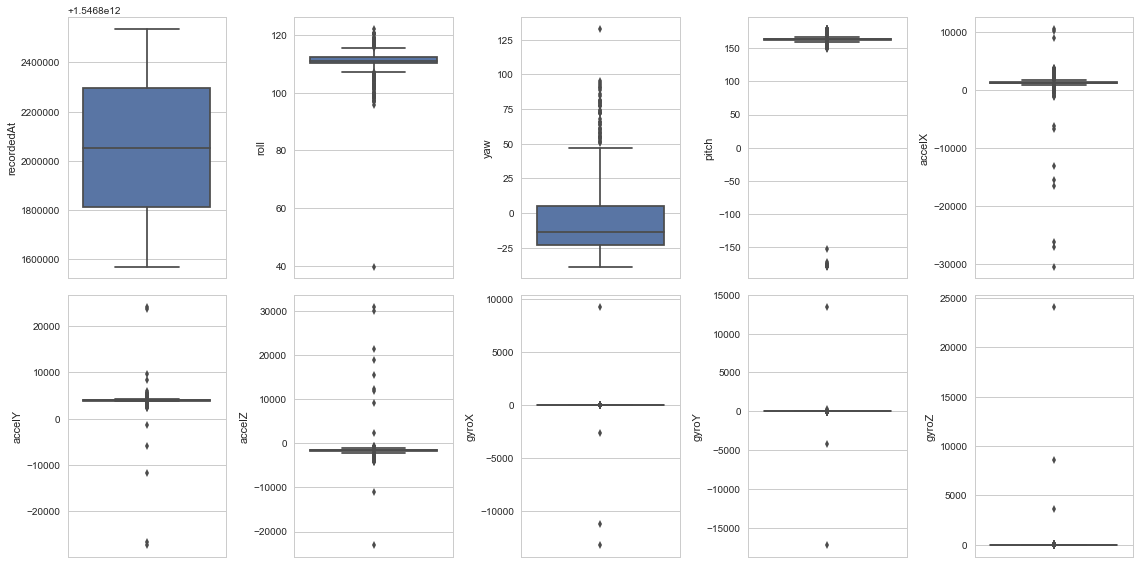

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,8))
sns.set(font_scale=1)
for i, ax in enumerate(axes.flatten()):
    sns.boxplot(x= df.iloc[:, i],  orient='v' , ax=ax)
fig.tight_layout()

In [12]:
def outliers(x):
    return np.abs(x-x.median()) > 1.5*(x.quantile(.95)-x.quantile(.05))

In [13]:
def replace(x): # x is a vector
    out = outliers(x)
    outlier = x[out]
    line = x.mode()[0]
    a = x[~out]
    maximum = a[a > line].median()
    minimum = a[a > line].median()
    x = x.replace(outlier.loc[out < line], minimum)
    x = x.replace(outlier.loc[out > line], maximum)
    return x

### 經過濾掉 outliers 的步驟後，得到的結果如下

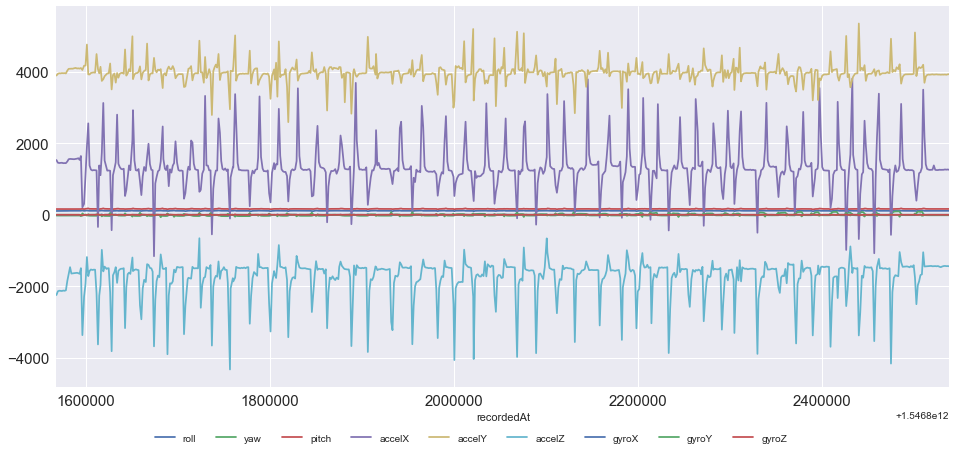

In [14]:
for x in df.iloc[:,1:]:
    df[x] = replace(df[x])
df.plot(x='recordedAt', figsize=(16,7), legend=True, fontsize=15).legend(
    loc=2, bbox_to_anchor=(0.1, -0.1), fancybox=True, ncol=9)

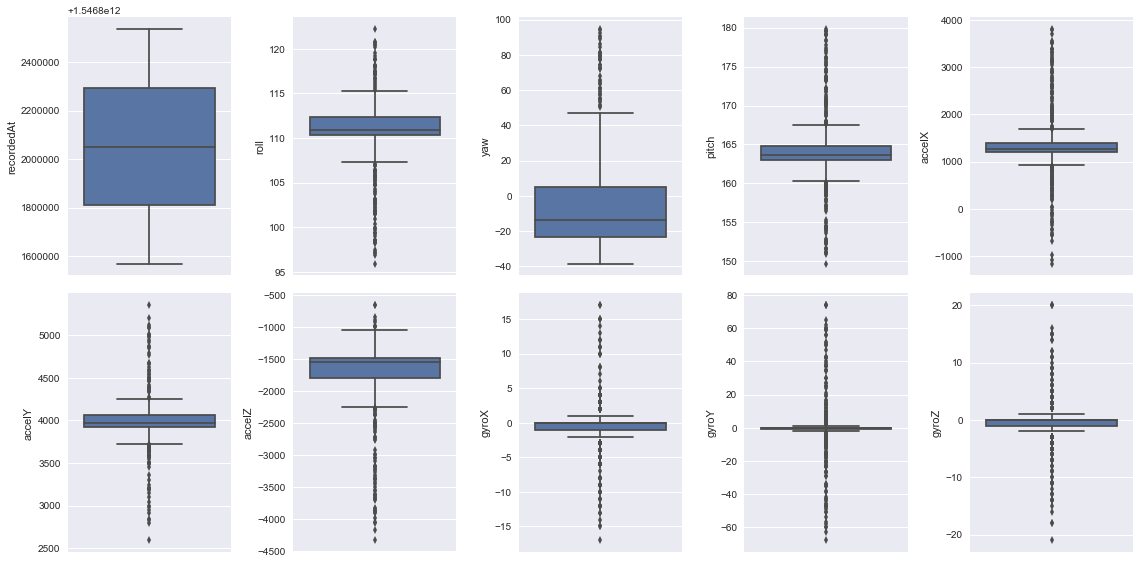

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,8))
sns.set(font_scale=1)
for i, ax in enumerate(axes.flatten()):
    sns.boxplot(x= df.iloc[:, i],  orient='v' , ax=ax)
fig.tight_layout()

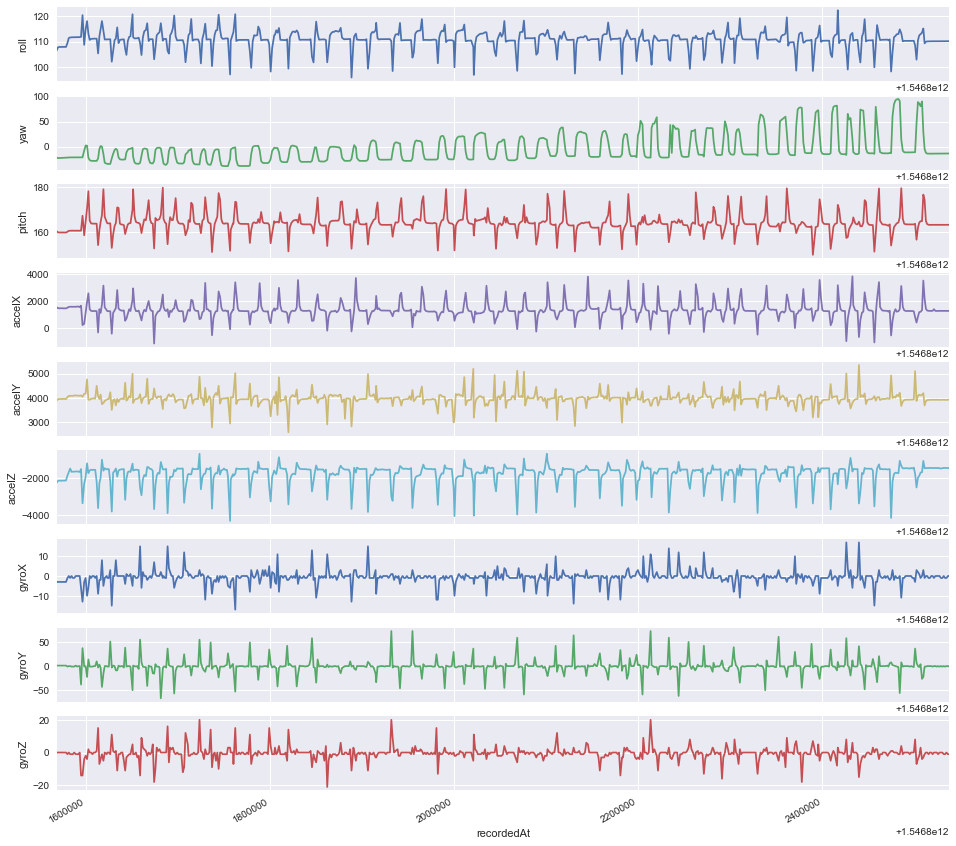

In [16]:
plot = df.plot(x='recordedAt', subplots=True, legend=False, kind='line', 
               grid=True, figsize=(16,16), sharey=False, sharex=True)
for x in range(0,plot.size):
    plot[x].set_ylabel(df.columns[x+1])

### 下面整理出在用肉眼觀察資料變化時候，所發現較有規律的三個指標，分別是 yaw, roll, gyroY

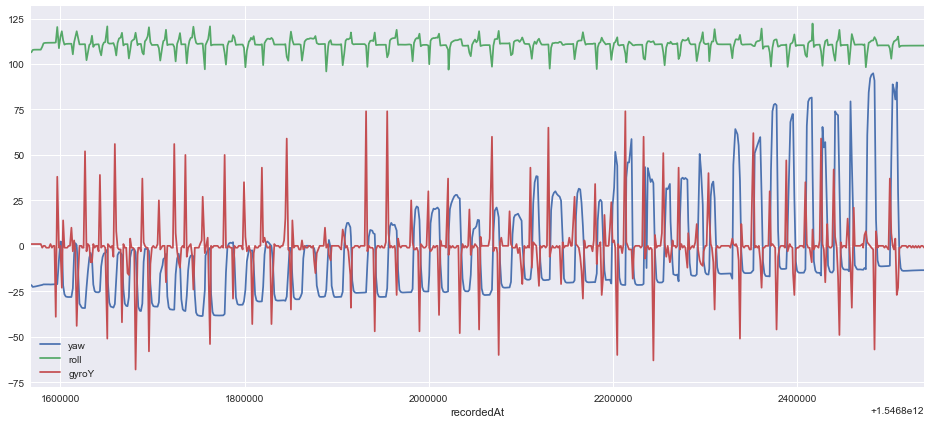

In [17]:
df[['recordedAt', 'yaw', 'roll', 'gyroY']].plot(x='recordedAt', figsize=(16,7))

## Step 3-2: Preprocessing: normalization
### 因為資料的區間過大，因此使用 normalization 將資料縮放到 [-1, 1] 之間

In [18]:
# normalization
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
df.iloc[:,1:] = scaler.fit_transform(df.iloc[:,1:])

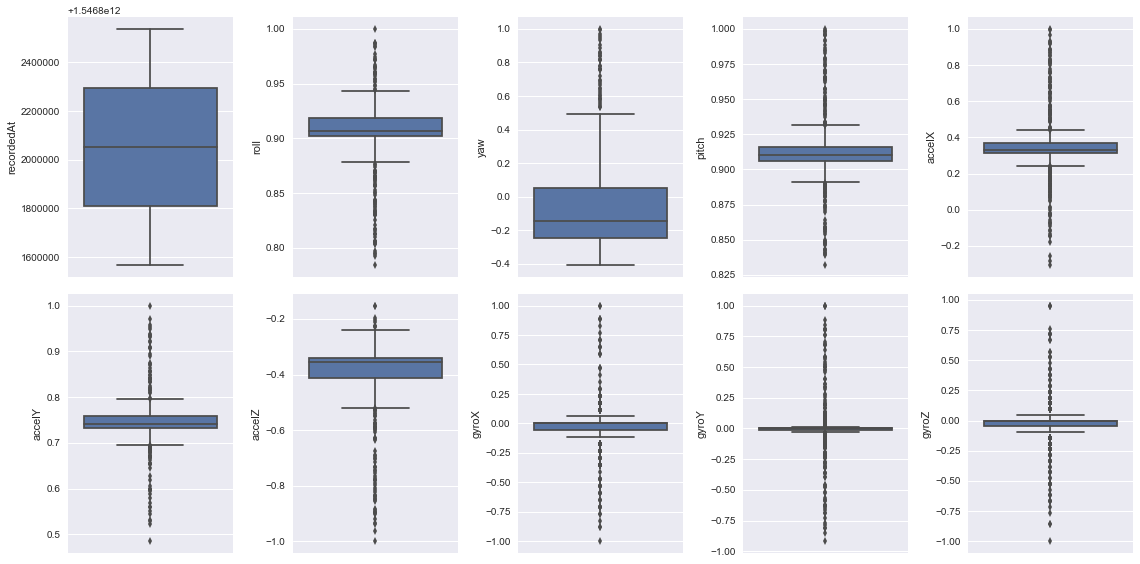

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,8))
sns.set(font_scale=1)
for i, ax in enumerate(axes.flatten()):
    sns.boxplot(x= df.iloc[:, i],  orient='v' , ax=ax)
fig.tight_layout()

## Step 4: Cut data

### references:
1. [python大資料分析——連續屬性離散化]('https://www.itread01.com/content/1543470602.html')

### 4-1 Give data a tag

In [20]:
# 0: non
# 1: pick up
# 2: put down
df['label'] = 0
df.loc[df.gyroY > df.gyroY.std(), 'label'] = 1
df.loc[df.gyroY < -df.gyroY.std(), 'label'] = 2

### 4-2 PCA

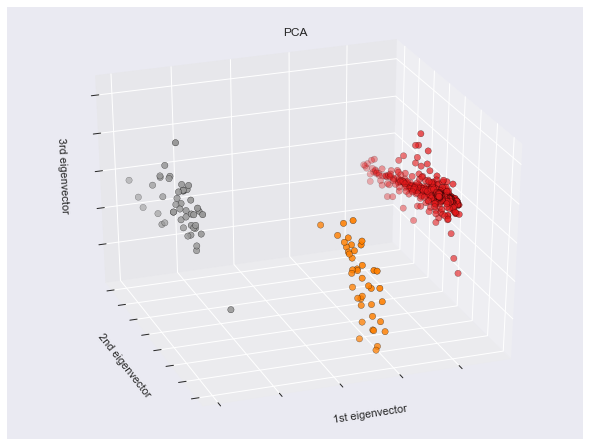

In [21]:
X = np.matrix(df.drop(['recordedAt'], axis=1))
Y = np.array(df['label'])

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)

X_reduced= PCA(n_components=3).fit_transform(X)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("PCA")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])
plt.show()

### 4-3 SVM

In [22]:
# Input Data Preparation
X = np.matrix(df.drop(['recordedAt'], axis=1))
Y = np.array(df['label'])

print(X.shape)
print(Y.shape)
print(sum(Y)/len(Y))

(648, 10)
(648,)
0.208333333333


In [23]:
x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=12)

print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(518, 10)
(130, 10)
(518,)
(130,)


In [24]:
from sklearn.svm import SVC
svm = SVC(C=1, kernel='linear')
svm.fit(x_train, y_train) 

y_pred = svm.predict(x_train)
print("Train: Number of mislabeled points out of a total %d points : %d" % (x_train.shape[0], pd.Series(y_train != y_pred).astype(int).sum()))
y_pred = svm.predict(x_valid)
print("Valid: Number of mislabeled points out of a total %d points : %d" % (x_valid.shape[0], pd.Series(y_valid != y_pred).astype(int).sum()))

Train: Number of mislabeled points out of a total 518 points : 0
Valid: Number of mislabeled points out of a total 130 points : 0


## Step 5: Prediction

In [25]:
import firebase_admin
from firebase_admin import credentials
from firebase_admin import db

# Fetch the service account key JSON file contents
cred = credentials.Certificate('smart-sensor-tag-firebase-adminsdk-qorgv-cbf66e542c.json')

# Initialize the app with a service account, granting admin privileges
firebase_admin.initialize_app(cred, {
    'databaseURL': 'https://smart-sensor-tag.firebaseio.com/'
})

In [26]:
def getDataByRef(name):
    ref = db.reference('/' + name)
    return ref.get()

In [27]:
def convertDataToDf(data):
    data = getDataByRef('0001')
    df = [val for val in data.values()]
    df = pd.DataFrame(df)
    cols = ['timestamp', 'roll', 'yaw', 'pitch', 
            'accelX', 'accelY', 'accelZ',
            'gyroX', 'gyroY', 'gyroZ']
    df = df[cols]
    df.timestamp = df.timestamp.astype('int64')
    df.iloc[:,1:4] = df.iloc[:,1:4].astype('float64')
    df.iloc[:,4:] = df.iloc[:,4:].astype('int64')
    df.timestamp = df.timestamp.apply(lambda x : x % 10000000)
    df.sort_values(by=['timestamp'])
    return df

In [28]:
data = getDataByRef('0001')
df_test = convertDataToDf(data)
df_test.head()

,timestamp,roll,yaw,pitch,accelX,accelY,accelZ,gyroX,gyroY,gyroZ
0,7215803,106.32,-20.41,160.73,1287,3850,-1985,-3,1,0
1,7215806,106.32,-19.98,160.72,1287,3847,-1981,-3,1,0
2,7215809,106.30,-19.66,160.72,1289,3846,-1970,-3,1,0
3,7215811,109.70,-19.49,161.44,1439,3958,-1481,-1,-2,0
4,7215814,103.97,-26.26,150.00,511,4011,-2113,6,28,-8


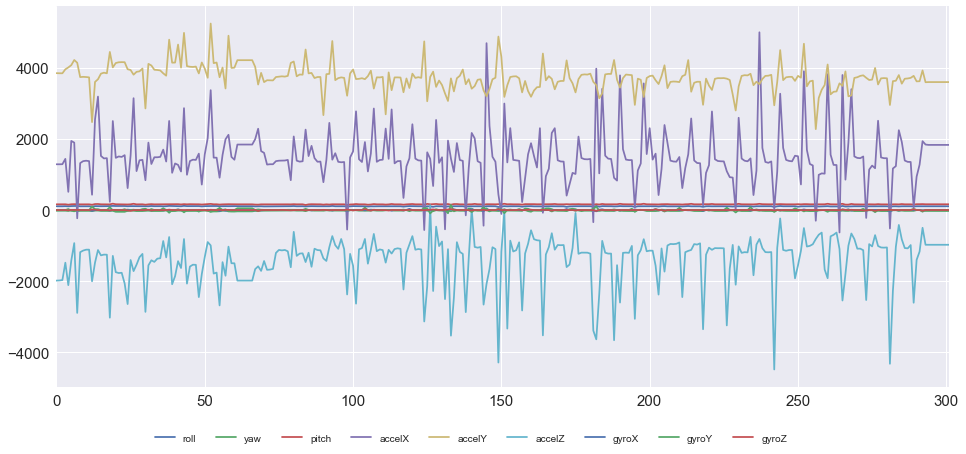

In [29]:
# preprocessing
for x in df_test.iloc[:,1:]:
    df_test[x] = replace(df_test[x])
df_test.iloc[:,1:].plot(figsize=(16,7), legend=True, fontsize=15).legend(
    loc=2, bbox_to_anchor=(0.1, -0.1), fancybox=True, ncol=9)

In [30]:
# normalization
scaler = MaxAbsScaler()
df_test.iloc[:,1:] = scaler.fit_transform(df_test.iloc[:,1:])

In [31]:
ID = df_test['timestamp']
X_test = np.matrix(df_test)

# svm = SVC(C=1, kernel='linear')
# svm.fit(x_train, y_train) 
# y_pred = bst.predict(xgb.DMatrix(X_test))
y_pred = svm.predict(X_test)
print(X_test.shape)
print(y_pred.shape)

(302, 10)
(302,)


In [32]:
df_submit = pd.DataFrame()
df_submit['timestamp'] = ID
df_submit['label'] = (y_pred > 0.5) * 1
# df_submit['Survived'] = 0
df_submit.to_csv("submit.csv", index=False)

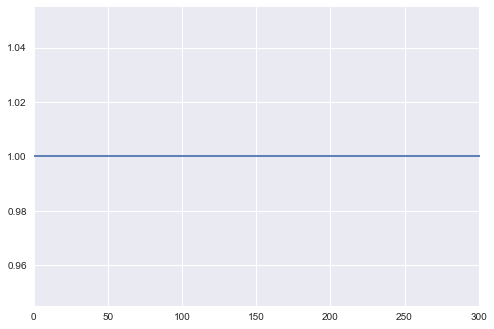

In [33]:
df_submit.label.plot()